# Project NLP Challenge

Explain what the project is for, and quickly how we are going to do it

In [9]:
# Import dataset
import pandas as pd
df = pd.read_csv("./dataset/training_data_lowercase.csv", sep='\t', header=None, names=["label", "title"], engine='python')
df.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [10]:
print(df.info())
print(df['label'].value_counts())
print(df['title'].apply(len).describe())  # length of text stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34152 non-null  int64 
 1   title   34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB
None
label
0    17572
1    16580
Name: count, dtype: int64
count    34152.000000
mean        74.680839
std         23.460862
min          2.000000
25%         61.000000
50%         70.000000
75%         85.000000
max        279.000000
Name: title, dtype: float64


In [11]:
import re

def clean_text(text):
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters and spaces
    return text

df['clean_title'] = df['title'].apply(clean_text)

In [12]:
X = df['clean_title']
y = df['label']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3529
           1       0.93      0.95      0.94      3302

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831

Accuracy: 0.9446640316205533


Let's try to pre-process more and also use Bert

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_advanced(text):
    text = re.sub(r'[^a-z\s]', '', text)  # keep letters only
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['title'].str.lower().apply(clean_text_advanced)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rospi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rospi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
from transformers import BertTokenizer, BertModel
import torch

# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Make sure model is in eval mode (no training here)
bert_model.eval()

C:\Users\rospi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
#Function to get BERT embedding for a single text
def get_bert_embedding(text):
    with torch.no_grad():  # no gradients needed
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        outputs = bert_model(**inputs)
        # outputs.last_hidden_state shape: (batch_size=1, seq_len, hidden_size=768)
        # CLS token embedding is the first token
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [20]:
import numpy as np

# Apply on all titles 
from tqdm import tqdm

X_bert = np.array([get_bert_embedding(text) for text in tqdm(df['title'])])

  0%|          | 0/34152 [00:00<?, ?it/s]

100%|██████████| 34152/34152 [30:29<00:00, 18.67it/s]  


In [21]:
from sklearn.model_selection import train_test_split

y = df['label'].values
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model_bert = LogisticRegression(max_iter=1000)
model_bert.fit(X_train_bert, y_train)

y_pred_bert = model_bert.predict(X_test_bert)

print(classification_report(y_test, y_pred_bert))
print("Accuracy with BERT embeddings:", accuracy_score(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3529
           1       0.95      0.95      0.95      3302

    accuracy                           0.96      6831
   macro avg       0.96      0.96      0.96      6831
weighted avg       0.96      0.96      0.96      6831

Accuracy with BERT embeddings: 0.9553506075245206


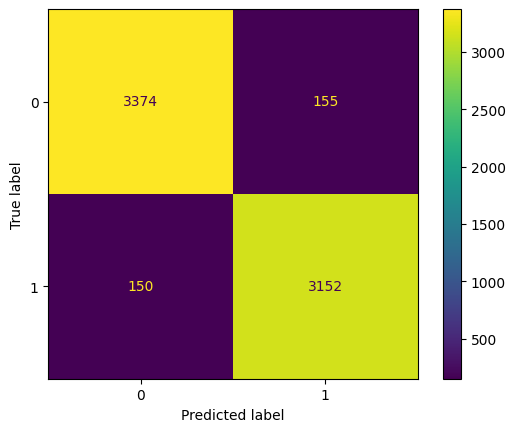

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_bert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [36]:
# Convert 2 to 0 or 1 in the file testing_data_lowercase_nolabels
# Import dataset
dt = pd.read_csv("./dataset/testing_data_lowercase_nolabels.csv", encoding="utf-8-sig")
dt.head()

,2\tcopycat muslim terrorist arrested with assault weapons
0,2\twow! chicago protester caught on camera adm...
1,2\tgermany's fdp look to fill schaeuble's big ...
2,2\tmi school sends welcome back packet warning...
3,2\tu.n. seeks 'massive' aid boost amid rohingy...
4,2\tdid oprah just leave ‚nasty‚ hillary wishin...


In [37]:
# Separate the values and add headers
dt[['label', 'title']] = dt[dt.columns[0]].str.split('\t', n=1, expand=True)

# Remove BOM and whitespace, then convert label to integer
dt['label'] = dt['label'].str.replace('\ufeff', '', regex=False).str.strip().astype(int)

# Reorder columns if needed
dt = dt[['label', 'title']]

# Show the result
dt.head()

,label,title
0,2,wow! chicago protester caught on camera admits...
1,2,germany's fdp look to fill schaeuble's big shoes
2,2,mi school sends welcome back packet warning ki...
3,2,u.n. seeks 'massive' aid boost amid rohingya '...
4,2,did oprah just leave ‚nasty‚ hillary wishing s...


BERT - Final accuracy on dt: 1.0000
BERT - Final log loss on dt: 0.0431


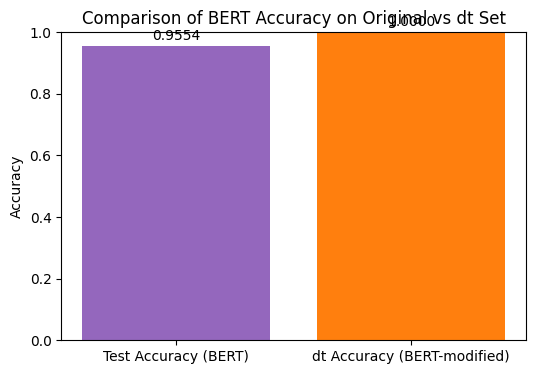

In [39]:
# Step 1: BERT embeddings for test data
from tqdm import tqdm
dt['bert_embedding'] = dt['title'].apply(lambda x: get_bert_embedding(x))

# Step 2: Convert list of embeddings to array
X_dt_bert = np.vstack(dt['bert_embedding'].values)

# Step 3: Predict using trained BERT-based model
dt_pred_bert = model_bert.predict(X_dt_bert)
dt_proba_bert = model_bert.predict_proba(X_dt_bert)

# Step 4: Replace label '2' with predicted values (keep 0 and 1 intact)
dt['label'] = dt.apply(lambda row: dt_pred_bert[row.name] if row['label'] == 2 else row['label'], axis=1)

# Step 5: Evaluate
from sklearn.metrics import accuracy_score, log_loss

y_dt_true = dt['label'].values
y_dt_pred_final = model_bert.predict(X_dt_bert)
y_dt_proba_final = model_bert.predict_proba(X_dt_bert)

dt_accuracy_bert = accuracy_score(y_dt_true, y_dt_pred_final)
dt_loss_bert = log_loss(y_dt_true, y_dt_proba_final)

print(f"BERT - Final accuracy on dt: {dt_accuracy_bert:.4f}")
print(f"BERT - Final log loss on dt: {dt_loss_bert:.4f}")

# Step 6: Visualization
import matplotlib.pyplot as plt

metrics = ['Test Accuracy (BERT)', 'dt Accuracy (BERT-modified)']
values = [accuracy_score(y_test, y_pred_bert), dt_accuracy_bert]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['tab:purple', 'tab:orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of BERT Accuracy on Original vs dt Set')

# Annotate bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f"{value:.4f}", ha='center', va='bottom')

plt.show()